### Imports

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgbm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


### Read files & submission file for template

In [17]:
X_train = pd.read_csv('X_train.csv',index_col='ROW_ID')
X_test = pd.read_csv('X_test.csv',index_col='ROW_ID')

y_train = pd.read_csv('y_train.csv',index_col='ROW_ID')
sample_submission = pd.read_csv('sample_submission.csv',index_col='ROW_ID')

In [19]:
X_train.columns

Index(['TS', 'ALLOCATION', 'RET_20', 'RET_19', 'RET_18', 'RET_17', 'RET_16',
       'RET_15', 'RET_14', 'RET_13', 'RET_12', 'RET_11', 'RET_10', 'RET_9',
       'RET_8', 'RET_7', 'RET_6', 'RET_5', 'RET_4', 'RET_3', 'RET_2', 'RET_1',
       'SIGNED_VOLUME_20', 'SIGNED_VOLUME_19', 'SIGNED_VOLUME_18',
       'SIGNED_VOLUME_17', 'SIGNED_VOLUME_16', 'SIGNED_VOLUME_15',
       'SIGNED_VOLUME_14', 'SIGNED_VOLUME_13', 'SIGNED_VOLUME_12',
       'SIGNED_VOLUME_11', 'SIGNED_VOLUME_10', 'SIGNED_VOLUME_9',
       'SIGNED_VOLUME_8', 'SIGNED_VOLUME_7', 'SIGNED_VOLUME_6',
       'SIGNED_VOLUME_5', 'SIGNED_VOLUME_4', 'SIGNED_VOLUME_3',
       'SIGNED_VOLUME_2', 'SIGNED_VOLUME_1', 'AVG_DAILY_TURNOVER'],
      dtype='object')

### Features

In [20]:
RET_features = [f'RET_{i}' for i in range(1,20)]
SIGNED_VOLUME_features = [f'SIGNED_VOLUME_{i}' for i in range(1,20)]
TURNOVER_features = ['AVG_DAILY_TURNOVER']

In [21]:
for i in [3,5,10,15,20]:
    X_train[ f'AVERAGE_PERF_{i}'] = X_train[RET_features[:i]].mean(1)
    X_train[ f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_train.groupby('TS')[ f'AVERAGE_PERF_{i}'].transform('mean')
    
    X_test[ f'AVERAGE_PERF_{i}'] = X_test[RET_features[:i]].mean(1)
    X_test[ f'ALLOCATIONS_AVERAGE_PERF_{i}'] = X_test.groupby('TS')[ f'AVERAGE_PERF_{i}'].transform('mean')

In [22]:
features = RET_features + SIGNED_VOLUME_features + TURNOVER_features
features = features + [ f'AVERAGE_PERF_{i}' for i in [3,5,10,15,20]]
features = features + [ f'ALLOCATIONS_AVERAGE_PERF_{i}' for i in [3,5,10,15,20]]

### Fitting one simple Ridge

In [23]:
new_ridge = linear_model.Ridge(alpha=1e-2, fit_intercept=False)

new_ridge.fit(X_train[features].to_numpy(na_value=0),y_train.to_numpy(na_value=0))

preds_ridge = pd.DataFrame(new_ridge.predict(X_test[features].fillna(0).to_numpy(na_value=0)), index = sample_submission.index,columns=['target'])

/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/olivierf/stanford/QRT-Asset-Allocation-Performance-forecasting/QRT_venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: 

In [24]:
(preds_ridge>0).astype(int).to_csv('preds_ridge.csv')

In [10]:
train_dates = X_train['TS'].unique()
test_dates = X_test['TS'].unique()

print(train_dates[[2,3]])

n_splits = 5
scores = []
models = []
 
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    print (local_train_dates_ids, local_test_dates_ids)

['DATE_0003' 'DATE_0004']
[   0    1    2 ... 2770 2771 2772] [   9   10   14   15   22   23   27   33   37   53   57   64   69   70
   76   92   98  104  109  113  117  121  124  135  137  138  141  148
  156  169  179  182  188  191  192  195  196  202  215  217  224  227
  234  242  245  248  252  253  259  271  276  289  295  296  298  299
  302  306  311  314  317  320  326  332  333  346  351  352  353  361
  369  380  385  396  398  399  402  405  410  418  422  425  427  436
  438  443  446  452  454  457  463  465  478  480  482  483  485  487
  489  491  496  501  502  518  527  531  536  543  546  547  553  558
  562  563  564  565  566  567  569  578  581  582  597  600  610  616
  618  619  621  628  636  638  641  652  654  666  670  672  674  675
  676  682  683  686  688  692  701  702  712  715  716  722  723  728
  731  745  746  764  766  768  776  781  791  794  806  812  820  831
  838  841  847  852  855  867  868  874  880  883  886  891  896  898
  899  900  905

### Fitting a random forest using cross validation

In [25]:

rf_params = {
    'n_estimators': 100,
    'max_depth': 2**5,
    'random_state': 42,
    'n_jobs': 40,
}

train_dates = X_train['TS'].unique()
test_dates = X_test['TS'].unique()

n_splits = 5
scores = []
models = []
 
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = X_train['TS'].isin(local_train_dates)
    local_test_ids = X_train['TS'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids,features]
    y_local_train = y_train.loc[local_train_ids,'target']
    X_local_test = X_train.loc[local_test_ids,features]
    y_local_test = y_train.loc[local_test_ids,'target']

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestRegressor(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict(X_local_test)
    
    models.append(model)
    score = accuracy_score((y_local_test>0).astype(int),
                (y_local_pred>0).astype(int))
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 51.15%
Fold 2 - Accuracy: 51.55%
Fold 3 - Accuracy: 51.65%
Fold 4 - Accuracy: 52.27%
Fold 5 - Accuracy: 51.74%
Accuracy: 51.67% [51.31 ; 52.03] (+- 0.36)


<Axes: >

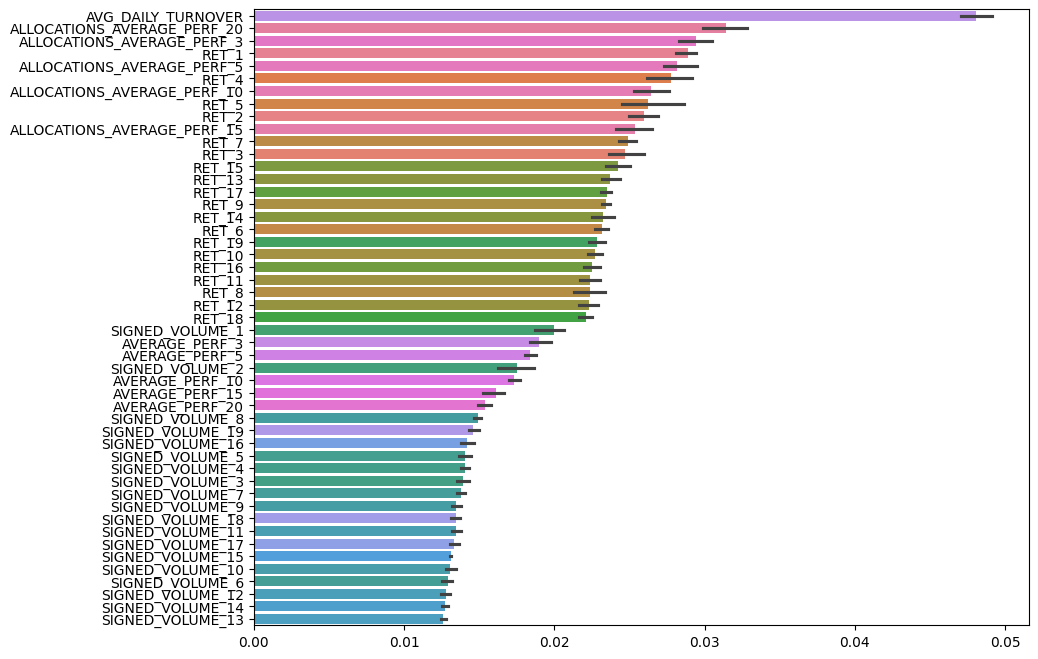

In [26]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

plt.figure(figsize=(10, 8))

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)


In [27]:
rf_params['random_state'] = 0
model = RandomForestRegressor(**rf_params)
model.fit(X_train[features].fillna(0), y_train['target'])
preds_rf = model.predict(X_test[features].fillna(0))
preds_rf = pd.DataFrame(preds_rf, index=sample_submission.index,columns=['target'])

KeyboardInterrupt: 

In [ ]:
(preds_rf>0).astype(int).to_csv('preds_rf.csv')

### Fitting a lightgbm using cross validation

In [ ]:

# A quite large number of trees with low depth to prevent overfits
lgbm_params = {
                "metric": "mse",
                "num_threads": 50,
                "seed": 42,
                "verbosity": -1,
                'learning_rate': 1e-3,
                'max_depth': 5,
}
NUM_BOOST_ROUND = 100

train_dates = X_train['TS'].unique()
test_dates = X_test['TS'].unique()

n_splits = 10
scores_lgbm = []
models_lgbm = []
 
splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True,).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = X_train['TS'].isin(local_train_dates)
    local_test_ids = X_train['TS'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids,features]
    y_local_train = y_train.loc[local_train_ids,'target']
    X_local_test = X_train.loc[local_test_ids,features]
    y_local_test = y_train.loc[local_test_ids,'target']

    X_local_train = X_local_train
    X_local_test = X_local_test

    train_data = lgbm.Dataset(X_local_train, label=y_local_train.values) 
    
    model_lgbm = lgbm.train(lgbm_params, train_data,num_boost_round=NUM_BOOST_ROUND) 
    
    y_local_pred = model_lgbm.predict(X_local_test.values, num_threads = lgbm_params['num_threads'])
    
    
    models_lgbm.append(model_lgbm)
    score = accuracy_score((y_local_test>0).astype(int),
                (y_local_pred>0).astype(int))
    scores_lgbm.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores_lgbm)*100
std = np.std(scores_lgbm)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 49.39%
Fold 2 - Accuracy: 51.01%
Fold 3 - Accuracy: 51.37%
Fold 4 - Accuracy: 50.24%
Fold 5 - Accuracy: 49.49%
Fold 6 - Accuracy: 50.16%
Fold 7 - Accuracy: 49.76%
Fold 8 - Accuracy: 50.39%
Fold 9 - Accuracy: 51.49%
Fold 10 - Accuracy: 50.25%
Accuracy: 50.36% [49.66 ; 51.05] (+- 0.70)


<Axes: >

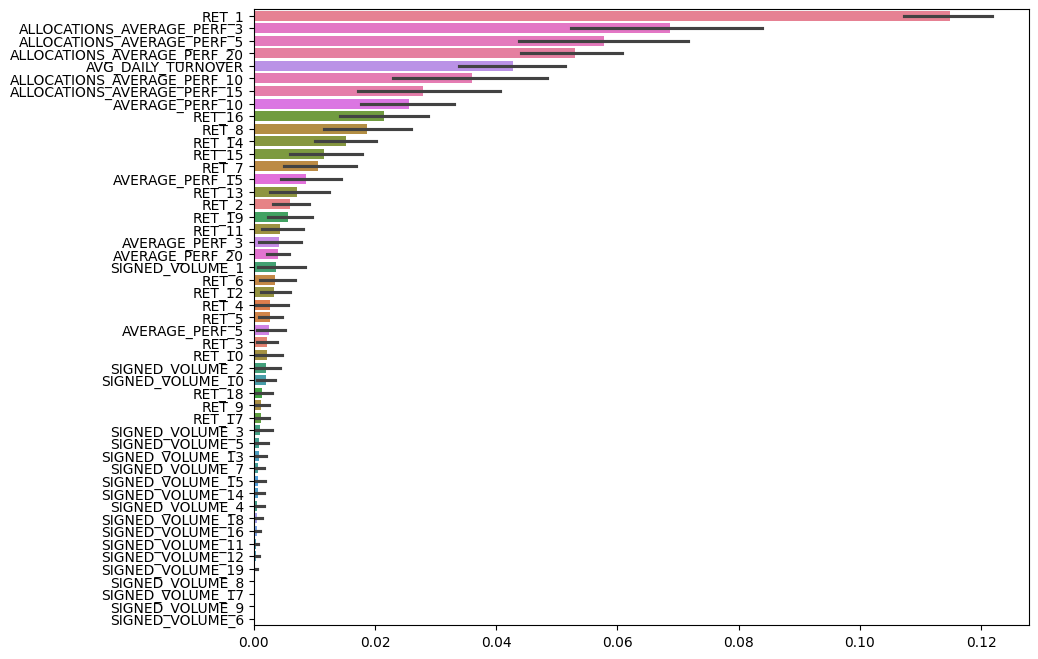

In [ ]:
feature_importances = pd.DataFrame([model_lgbm.feature_importance(importance_type='gain') for model_lgbm in models_lgbm], columns=features)

plt.figure(figsize=(10, 8))

sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)


In [ ]:
train_data = lgbm.Dataset(X_train[features], label=y_train) 
model_lgbm = lgbm.train(lgbm_params, train_data,num_boost_round=NUM_BOOST_ROUND) 
preds_lgbm = model_lgbm.predict(X_test[features])
preds_lgbm = pd.DataFrame(preds_lgbm, index=sample_submission.index,columns=['target'])

In [ ]:
(preds_lgbm>0).astype(int).to_csv('preds_lgbm.csv')